$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Data creation
<a id=part1></a>

we will start by setting up our datasets and dataloaders, then splitting data into train/validation/test sets

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})

In [3]:
import torchtext
from torchtext import data
from torchtext import datasets

# create Field objects
ID = data.Field(sequential=False, dtype=torch.int8, use_vocab=True)
TARGET = data.Field(sequential=False, lower=True, dtype=torch.long, use_vocab=True)
TWEET = data.Field(sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long)
STANCE = data.Field( is_target=True, sequential=False, unk_token=None, use_vocab=True)
SENTIMENT = data.Field( is_target=True, sequential=False, unk_token=None, use_vocab=True)

# create tuples representing the columns
fields = [
   ('ID', ID),
  ('TARGET', TARGET),
  ('TWEET', TWEET),
  ('STANCE', STANCE),
  (None, None), # ignore column
  ('SENTIMENT', SENTIMENT)
]


# load the dataset in json format
train_ds, valid_ds, test_ds = data.TabularDataset.splits(
   path = 'data-all-annotations',
   train = 'trainingdata-all-annotations.txt',
   validation = 'legalization_of_abortion_valid_set.txt',
   test = 'legalization_of_abortion_test_set.txt',
   format = 'tsv',
   fields = fields,
skip_header = True
)

# check an example
print(vars(train_ds[1]))
print(vars(valid_ds[100]))
print(len(train_ds))

{'ID': '102', 'TARGET': 'atheism', 'TWEET': ['blessed', 'are', 'the', 'peacemakers,', 'for', 'they', 'shall', 'be', 'called', 'children', 'of', 'god.', 'matthew', '5:9', '#scripture', '#peace', '#semst'], 'STANCE': 'AGAINST', 'SENTIMENT': 'POSITIVE'}
{'ID': '2413', 'TARGET': 'legalization of abortion', 'TWEET': ['@showtruth', 'no,', 'i', "can't", 'explain', 'why', 'you', 'would', 'consider', 'a', 'medical', 'procedure', 'that', 'leaves', 'the', 'patient', 'healthy', '&', 'happy', 'as', 'killing.', '#semst'], 'STANCE': 'FAVOR', 'SENTIMENT': 'NEGATIVE'}
2814


C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
C:\Users\User\anaconda3\envs\AI-project\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and mo

### Data Pre-processing
<a id=part1_3></a>

The first thing we'll need to build a vocabulary for our fields 

In [4]:
ID.build_vocab(train_ds)
TARGET.build_vocab(train_ds)
TWEET.build_vocab(train_ds)
STANCE.build_vocab(train_ds)
SENTIMENT.build_vocab(train_ds)

print(f"Number of tokens in training samples: {len(TWEET.vocab)}")
print(f"Number of tokens in training stance labels: {len(STANCE.vocab)}")
print(f"Number of tokens in training sentiment labels: {len(SENTIMENT.vocab)}")

Number of tokens in training samples: 12528
Number of tokens in training stance labels: 3
Number of tokens in training sentiment labels: 3


In [5]:
print(f'first 20 tokens:\n', TWEET.vocab.itos[:20], end='\n\n')

first 20 tokens:
 ['<unk>', '<pad>', '<sos>', '<eos>', '#semst', 'the', 'to', 'a', 'of', 'is', 'and', 'you', 'i', 'in', 'for', 'be', 'that', 'are', 'on', 'not']



In [6]:
print(f'stance labels vocab:\n', dict(STANCE.vocab.stoi))
print(f'sentiment labels vocab:\n', dict(SENTIMENT.vocab.stoi))

stance labels vocab:
 {'AGAINST': 0, 'NONE': 1, 'FAVOR': 2}
sentiment labels vocab:
 {'NEGATIVE': 0, 'POSITIVE': 1, 'NEITHER': 2}


# Data Loaders

we want to be able to create batches and to iterate through the datasets for that we need to define data loaders 


In [8]:
BATCH_SIZE = 10

dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (train_ds, valid_ds, test_ds), batch_size=BATCH_SIZE,
    shuffle=True, sort=False)

this is what a single batch looks like

In [10]:
batch = next(iter(dl_train))

X, y_stance, y_sentiment= batch.TWEET, batch.STANCE, batch.SENTIMENT
print('X = \n', X, X.shape, end='\n\n')
print('y = \n', y_stance, y_stance.shape)

X = 
 tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2],
        [  373,    50,  6289,   382,  2339,    50,  4888,    29,  6443,  5653],
        [   17,  6742,  6351,   132,  5739,  6114,  6127,   310,   166,   251],
        [ 1281,  2250,  2320,   639,  5718,  6008,    64,    29,    11,   534],
        [    6, 12037,   250,    22,    58,   627,    17,    33,    14,   185],
        [ 3424,   685,    35,  6795,   927,    48,    11,    17,     5,    24],
        [  649,  4236,   131,  9151,   300,     7,   617,  1143,   119,  1920],
        [ 2689,   563,    14,    29,     5,   134,    19,     6,    11,    94],
        [10997,  7117,    27,   197,   519,  8493,  3181,   428,  2451,  1359],
        [   29,  2125,  7116,    87,   774,   707,    27,  9946,  7767,    57],
        [  172,  5342,     4,   995,     9,     9,    48,  7897,     5,   259],
        [   29,  4240,     3,     4,   391,     5,  7932, 10540,  1313,    25],
        [    6, 12427,     1,     

# Model Implementation

In our problem stands the difficulties of stance detection, where the sentiment is not generic but with respect to a specific topic. 
as stated in our proposed solution we will build a RNN based deep neural network within a two-phase architecture,
first we will experiment with a more sophisticated version of RNN which is the LSTM architecture. 

#### the two-phase architecture

the first phase (Subjectivity classification):
1. Layer of embedding
2. Layer of LSTM 
3. Linear classification layer  classify (positive \ negative \ neutral)

testing the model:

In [14]:
from implementations.models import SubjectivityLSTM

EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2
DROP_OUT = 0.1
VOCAB_SIZE = len(TWEET.vocab)

sub = SubjectivityLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
out, h, ht = sub(X)
print(f'h (S, B, H): {h.shape}')
print(f'ht (L, B, H): {ht[0].shape}')
print(f'out (S, B, H): {out.shape}')

h (S, B, H): torch.Size([23, 10, 64])
ht (L, B, H): torch.Size([2, 10, 64])
out (S, B, H): torch.Size([23, 10, 3])



the second phase (Stance detection):
1. Layer of attention
2. Layer of LSTM
3. Linear classification layer classify (favor \ against).

In [15]:
from implementations.models import StanceLSTM

stance = StanceLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
yhat, _ = stance(X, ht, h)
print(f'yhat (S, B, V_tgt): {yhat.shape}')

yhat (S, B, V_tgt): torch.Size([23, 10, 3])


now for the model that includes both

In [17]:
from implementations.models import TwoPhaseLSTM

two_phase_model = TwoPhaseLSTM(sub, stance)
y_stance, y_sub = two_phase_model(X)
print('y_stance: (S, B, V_tgt) =', tuple(y_stance.shape))
print('y_sub: (S, B, V_tgt) =', tuple(y_sub.shape))

y_stance: (S, B, V_tgt) = (23, 10, 3)
y_sub: (S, B, V_tgt) = (23, 10, 3)


# training

The trainnig approarch will be standard approach with CrossEntropy loss on the class scores and calculating number of correct answers for accuracy evaluation

first we will run on the validation set and try to overfit:

In [18]:
from implementations.training import train_two_phase_rnn
from implementations.training import eval_two_phase_rnn
import torch.nn as nn

EPOCHS = 100
BATCHES_PER_EPOCH=28
LR=1e-3

optimizer = torch.optim.Adam(two_phase_model.parameters(), lr=LR)
sub_loss_fn = nn.NLLLoss()
stance_loss_fn = nn.NLLLoss()

losses = []
sub_accuracies = []
stance_accuracies = []
for epoch in range(EPOCHS):
    
    print(f'=== EPOCH {epoch+1}/{EPOCHS} ===')
    losses += train_two_phase_rnn(two_phase_model, dl_train, optimizer, sub_loss_fn, stance_loss_fn, BATCHES_PER_EPOCH)
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model, dl_valid)
    sub_accuracies += sub_acc
    stance_accuracies += stance_acc


=== EPOCH 1/100 ===
train loss=1.0473012924194336,: 100%|██████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.11it/s]
 sentiment accuracy=0.6200000047683716, stance accuracy=0.5166667103767395 : 100%|█████| 30/30 [00:01<00:00, 19.49it/s]
=== EPOCH 2/100 ===
train loss=1.1591650247573853,: 100%|██████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.42it/s]
 sentiment accuracy=0.6200000047683716, stance accuracy=0.5166666507720947 : 100%|█████| 30/30 [00:01<00:00, 19.50it/s]
=== EPOCH 3/100 ===
train loss=1.0144431591033936,: 100%|██████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.78it/s]
 sentiment accuracy=0.6200000047683716, stance accuracy=0.5166666507720947 : 100%|█████| 30/30 [00:01<00:00, 17.95it/s]
=== EPOCH 4/100 ===
train loss=1.1721436977386475,: 100%|██████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.24it/s]
 sentiment accuracy=0.6200000643730164, stance accuracy=0.5166666507720947 : 100

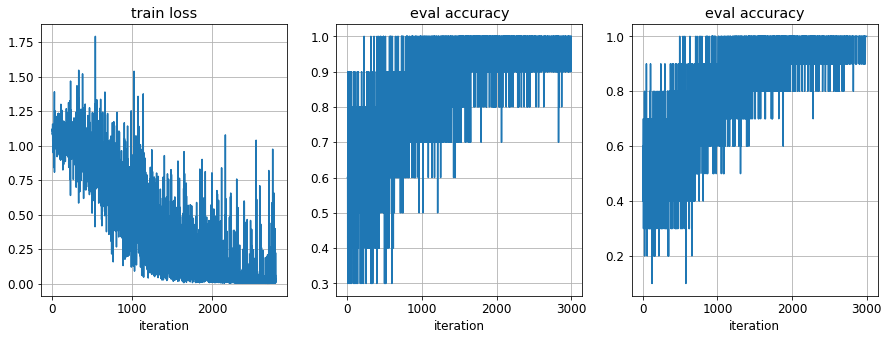

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
ax[2].plot(stance_accuracies); ax[2].set_title('stance accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)

now we will run it on test

In [14]:
losses = []
sub_accuracies = []
stance_accuracies = []
for epoch in range(EPOCHS):
    
    print(f'=== test EPOCH {epoch+1}/{EPOCHS} ===')
    losses += train_two_phase_rnn(two_phase_model, dl_train, optimizer, sub_loss_fn, stance_loss_fn, BATCHES_PER_EPOCH)
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model, dl_test)
    sub_accuracies += sub_acc
    stance_accuracies += stance_acc

=== test EPOCH 1/100 ===
train loss=0.002683110535144806,: 100%|████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.86it/s]
 sentiment accuracy=0.5880952477455139, stance accuracy=0.39444443583488464 : 100%|████| 28/28 [00:00<00:00, 47.92it/s]
=== test EPOCH 2/100 ===
train loss=0.0032960802782326937,: 100%|███████████████████████████████████████████████| 28/28 [00:03<00:00,  8.73it/s]
 sentiment accuracy=0.6007935404777527, stance accuracy=0.36190471053123474 : 100%|████| 28/28 [00:00<00:00, 47.17it/s]
=== test EPOCH 3/100 ===
train loss=0.019864089787006378,: 100%|████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.83it/s]
 sentiment accuracy=0.5916666984558105, stance accuracy=0.3869047462940216 : 100%|█████| 28/28 [00:00<00:00, 47.61it/s]
=== test EPOCH 4/100 ===
train loss=0.003009531181305647,: 100%|████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.74it/s]
 sentiment accuracy=0.5988095998764038, stance accuracy=0.40

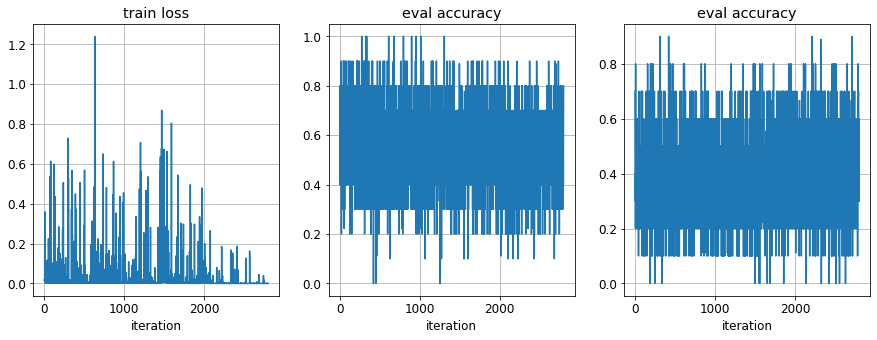

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(sub_accuracies); ax[1].set_title('eval accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
ax[2].plot(stance_accuracies); ax[2].set_title('eval accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)

# Experiments

in our experiments we intend to find the right parameters that would bring a  stabilized training, prevent overfitting and result in high accuracies

### hyper parameters

1. dropout: which for some probability disconnects layers in the model preventing our model from overfitting while training
2. bach size: the number of batches we split our input into in order to train the model
3. epochs: the number of epoch our model trains
4. batches each epoch: number of max batches in each epoch 
5. learn rate: the rate in which we want the loss function to converge.
6. embedding dimension: the dimension we use for embedding the meaning of the words 
7. hidden dimensions: the hidden dimensions of the rnn layers we have in our models 
8. number of layers: the number of layers in our rnns


In [16]:
EMB_DIM = 256
HID_DIM = 128
NUM_LAYERS = 2
DROP_OUT = 0.5
VOCAB_SIZE = len(TWEET.vocab)
EPOCHS = 100
BATCHES_PER_EPOCH=30
LR=1e-3

sub = SubjectivityLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
out, h, ht = sub(X)
stance = StanceLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
yhat, _ = stance(X, ht, h)
two_phase_model = TwoPhaseLSTM(sub, stance)
y_stance, y_sub = two_phase_model(X)


optimizer = torch.optim.Adam(two_phase_model.parameters(), lr=LR)
sub_loss_fn = nn.NLLLoss()
stance_loss_fn = nn.NLLLoss()

losses = []
sub_accuracies = []
stance_accuracies = []
for epoch in range(EPOCHS):
    
    print(f'=== EPOCH {epoch+1}/{EPOCHS} ===')
    losses += train_two_phase_rnn(two_phase_model, dl_train, optimizer, sub_loss_fn, stance_loss_fn, BATCHES_PER_EPOCH)
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model, dl_valid)
    sub_accuracies += sub_acc
    stance_accuracies += stance_acc

=== EPOCH 1/100 ===
train loss=0.9589030146598816,: 100%|██████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.41it/s]
 sentiment accuracy=0.6200000047683716, stance accuracy=0.51666659116745 : 100%|███████| 30/30 [00:00<00:00, 31.91it/s]
=== EPOCH 2/100 ===
train loss=1.056846261024475,: 100%|███████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.52it/s]
 sentiment accuracy=0.6200000047683716, stance accuracy=0.5166667103767395 : 100%|█████| 30/30 [00:00<00:00, 31.81it/s]
=== EPOCH 3/100 ===
train loss=1.157275676727295,: 100%|███████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.76it/s]
 sentiment accuracy=0.6200000643730164, stance accuracy=0.5233333110809326 : 100%|█████| 30/30 [00:00<00:00, 32.39it/s]
=== EPOCH 4/100 ===
train loss=1.0517055988311768,: 100%|██████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.62it/s]
 sentiment accuracy=0.6199999451637268, stance accuracy=0.5166667103767395 : 100

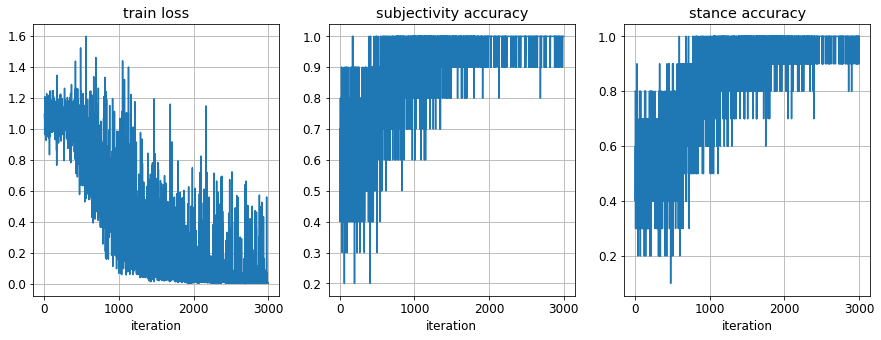

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
ax[2].plot(stance_accuracies); ax[2].set_title('stance accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)

In [18]:
EPOCHS = 10
losses = []
sub_accuracies = []
stance_accuracies = []
for epoch in range(EPOCHS):
    
    print(f'=== test EPOCH {epoch+1}/{EPOCHS} ===')
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model, dl_test)
    sub_accuracies += sub_acc
    stance_accuracies += stance_acc

=== test EPOCH 1/10 ===
 sentiment accuracy=0.7210317850112915, stance accuracy=0.6519841551780701 : 100%|█████| 28/28 [00:00<00:00, 33.09it/s]
=== test EPOCH 2/10 ===
 sentiment accuracy=0.720238208770752, stance accuracy=0.6230158805847168 : 100%|██████| 28/28 [00:00<00:00, 33.59it/s]
=== test EPOCH 3/10 ===
 sentiment accuracy=0.735714316368103, stance accuracy=0.598412811756134 : 100%|███████| 28/28 [00:00<00:00, 32.27it/s]
=== test EPOCH 4/10 ===
 sentiment accuracy=0.7166666388511658, stance accuracy=0.6388888955116272 : 100%|█████| 28/28 [00:00<00:00, 32.41it/s]
=== test EPOCH 5/10 ===
 sentiment accuracy=0.7242063879966736, stance accuracy=0.6170634627342224 : 100%|█████| 28/28 [00:00<00:00, 33.69it/s]
=== test EPOCH 6/10 ===
 sentiment accuracy=0.7202381491661072, stance accuracy=0.613095223903656 : 100%|██████| 28/28 [00:00<00:00, 34.19it/s]
=== test EPOCH 7/10 ===
 sentiment accuracy=0.7238094210624695, stance accuracy=0.6198412179946899 : 100%|█████| 28/28 [00:00<00:00, 33.

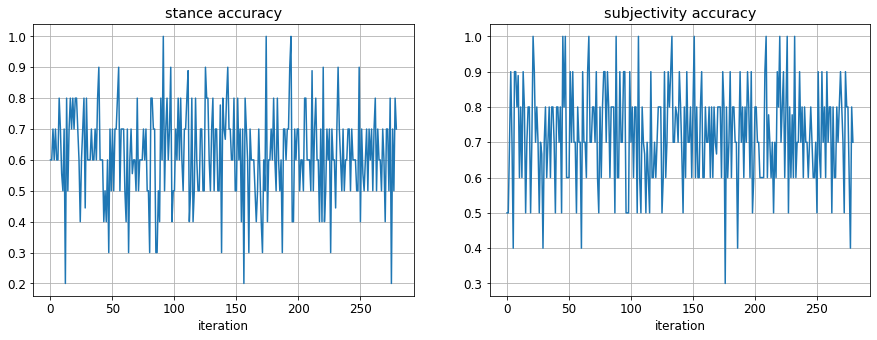

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(stance_accuracies); ax[0].set_title('stance accuracy'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)


## experimenting with different models 

here we try to run expirements with the same architecture but with different RNN models:
1. GRU
2. RNN


In [27]:
from implementations.models import SubjectivityGRU
from implementations.models import SubjectivityRNN

from implementations.models import StanceGRU
from implementations.models import StanceRNN

from implementations.models import TwoPhaseGRU
from implementations.models import TwoPhaseRNN

EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 2
DROP_OUT = 0.3
VOCAB_SIZE = len(TWEET.vocab)
EPOCHS = 100
BATCHES_PER_EPOCH=30
LR=1e-3

subGRU = SubjectivityGRU(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
stanceGRU = StanceGRU(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
two_phase_model_GRU = TwoPhaseGRU(subGRU, stanceGRU)

EMB_DIM = 128
HID_DIM = 64
NUM_LAYERS = 1
DROP_OUT = 0.1
VOCAB_SIZE = len(TWEET.vocab)
EPOCHS = 100
BATCHES_PER_EPOCH=30
LR=1e-3

subRNN = SubjectivityRNN(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
stanceRNN = StanceRNN(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
two_phase_model_RNN = TwoPhaseRNN(subRNN, stanceRNN)

EMB_DIM = 256
HID_DIM = 128
NUM_LAYERS = 2
DROP_OUT = 0.5
VOCAB_SIZE = len(TWEET.vocab)
EPOCHS = 100
BATCHES_PER_EPOCH=30
LR=1e-3

subLSTM = SubjectivityLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
stanceLSTM = StanceLSTM(VOCAB_SIZE, EMB_DIM, HID_DIM,NUM_LAYERS,DROP_OUT)
two_phase_model_LSTM = TwoPhaseLSTM(subLSTM, stanceLSTM)


optimizer_GRU = torch.optim.Adam(two_phase_model.parameters(), lr=LR)
sub_loss_fn_GRU = nn.NLLLoss()
stance_loss_fn_GRU = nn.NLLLoss()
optimizer_RNN = torch.optim.Adam(two_phase_model.parameters(), lr=LR)
sub_loss_fn_RNN = nn.NLLLoss()
stance_loss_fn_RNN = nn.NLLLoss()
optimizer_LSTM = torch.optim.Adam(two_phase_model.parameters(), lr=LR)
sub_loss_fn_LSTM = nn.NLLLoss()
stance_loss_fn_LSTM = nn.NLLLoss()

losses_GRU = []
sub_accuracies_GRU = []
stance_accuracies_GRU = []
losses_RNN = []
sub_accuracies_RNN = []
stance_accuracies_RNN = []
losses_LSTM = []
sub_accuracies_LSTM = []
stance_accuracies_LSTM = []
for epoch in range(EPOCHS):
    
    print(f'=== GRU EPOCH {epoch+1}/{EPOCHS} ===')
    losses_GRU += train_two_phase_rnn(two_phase_model_GRU, dl_train, optimizer_GRU, sub_loss_fn_GRU, stance_loss_fn_GRU, BATCHES_PER_EPOCH)
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model_GRU, dl_valid)
    sub_accuracies_GRU += sub_acc
    stance_accuracies_GRU += stance_acc
    
for epoch in range(EPOCHS):
    
    print(f'=== RNN EPOCH {epoch+1}/{EPOCHS} ===')
    losses_RNN += train_two_phase_rnn(two_phase_model_RNN, dl_train, optimizer_RNN, sub_loss_fn_RNN, stance_loss_fn_RNN, BATCHES_PER_EPOCH)
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model_RNN, dl_valid)
    sub_accuracies_RNN += sub_acc
    stance_accuracies_RNN += stance_acc  
    
for epoch in range(EPOCHS):
    
    print(f'=== LSTM EPOCH {epoch+1}/{EPOCHS} ===')   
    losses_LSTM += train_two_phase_rnn(two_phase_model_LSTM, dl_train, optimizer_LSTM, sub_loss_fn_LSTM, stance_loss_fn_LSTM, BATCHES_PER_EPOCH)
    sub_acc, stance_acc = eval_two_phase_rnn(two_phase_model_LSTM, dl_valid)
    sub_accuracies_LSTM += sub_acc
    stance_accuracies_LSTM += stance_acc
    


=== GRU EPOCH 1/100 ===
train loss=1.0654314756393433,: 100%|██████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.37it/s]
 sentiment accuracy=0.4300000071525574, stance accuracy=0.48333337903022766 : 100%|████| 30/30 [00:00<00:00, 45.51it/s]
=== GRU EPOCH 2/100 ===
train loss=1.1083303689956665,: 100%|██████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.41it/s]
 sentiment accuracy=0.4466666579246521, stance accuracy=0.4766665995121002 : 100%|█████| 30/30 [00:00<00:00, 43.85it/s]
=== GRU EPOCH 3/100 ===
train loss=1.0861138105392456,: 100%|██████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.29it/s]
 sentiment accuracy=0.4266666769981384, stance accuracy=0.47333329916000366 : 100%|████| 30/30 [00:00<00:00, 43.03it/s]
=== GRU EPOCH 4/100 ===
train loss=1.0784928798675537,: 100%|██████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.83it/s]
 sentiment accuracy=0.4366666078567505, stance accuracy=0.449999

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].plot(losses); ax[0].set_title('train loss'); ax[0].set_xlabel('iteration'); ax[0].grid(True)
ax[1].plot(sub_accuracies); ax[1].set_title('subjectivity accuracy'); ax[1].set_xlabel('iteration'); ax[1].grid(True)
ax[2].plot(stance_accuracies); ax[2].set_title('stance accuracy'); ax[2].set_xlabel('iteration'); ax[2].grid(True)